# Hidden Markov Model for Human Activity Recognition

## Project Overview
This notebook implements a Hidden Markov Model (HMM) to classify human activities (Standing, Walking, Still) using accelerometer and gyroscope data collected from smartphone sensors.

**Group Members:** Alain Michael Muhirwa, Joan Keza  
**Phone Models:** [Add phone models used]  
**Sampling Rates:** 100 HZ

In [111]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Data Collection and Loading

### Data Structure
- **Activities:** Standing, Still, Walking
- **Sensors:** Accelerometer (x, y, z), Gyroscope (x, y, z)
- **Format:** CSV files with columns: time, seconds_elapsed, z, y, x

In [112]:
# Data Loading Function
def load_sensor_data(base_path, person='Michael', activities=['Standing', 'Still', 'Walking', 'Jumping'], save_combined=True):
    """
    Load accelerometer and gyroscope data for all activities.
    Automatically detects and loads all sensor files (Accelerometer_1.csv, Accelerometer_2.csv, etc.)
    
    Parameters:
    -----------
    base_path : str
        Base path to data directory
    person : str
        Person's name (folder name)
    activities : list
        List of activity names
    save_combined : bool
        Whether to save combined data to CSV files
        
    Returns:
    --------
    dict : Dictionary containing DataFrames for each activity and sensor type
    """
    data = {}
    base = Path(base_path)
    
    # Create combined_data directory if saving
    if save_combined:
        combined_dir = base / 'combined_data'
        combined_dir.mkdir(exist_ok=True)
        print(f"Combined data will be saved to: {combined_dir}\n")
    
    for activity in activities:
        data[activity] = {}
        print(f"\n{'='*60}")
        print(f"Loading data for: {activity}")
        print('='*60)
        
        # Load all Accelerometer files
        accel_files = list((base / person / activity).glob('Accelerometer*.csv'))
        if accel_files:
            accel_dataframes = []
            for accel_file in sorted(accel_files):
                df = pd.read_csv(accel_file)
                df['sensor'] = 'accelerometer'
                df['activity'] = activity
                df['file_source'] = accel_file.name
                accel_dataframes.append(df)
                print(f"✓ Loaded {accel_file.name}: {len(df)} samples")
            
            # Combine all accelerometer data
            df_accel_combined = pd.concat(accel_dataframes, ignore_index=True)
            data[activity]['accelerometer'] = df_accel_combined
            print(f"  → Combined Accelerometer: {len(df_accel_combined)} total samples from {len(accel_files)} files")
            
            # Save combined accelerometer data
            if save_combined:
                combined_file = combined_dir / f'{person}_{activity}_Accelerometer_Combined.csv'
                df_accel_combined.to_csv(combined_file, index=False)
                print(f"  → Saved to: {combined_file.name}")
        else:
            print(f"✗ No Accelerometer files found in {base / person / activity}")
        
        # Load all Gyroscope files
        gyro_files = list((base / person / activity).glob('Gyroscope*.csv'))
        if gyro_files:
            gyro_dataframes = []
            for gyro_file in sorted(gyro_files):
                df = pd.read_csv(gyro_file)
                df['sensor'] = 'gyroscope'
                df['activity'] = activity
                df['file_source'] = gyro_file.name
                gyro_dataframes.append(df)
                print(f"✓ Loaded {gyro_file.name}: {len(df)} samples")
            
            # Combine all gyroscope data
            df_gyro_combined = pd.concat(gyro_dataframes, ignore_index=True)
            data[activity]['gyroscope'] = df_gyro_combined
            print(f"  → Combined Gyroscope: {len(df_gyro_combined)} total samples from {len(gyro_files)} files")
            
            # Save combined gyroscope data
            if save_combined:
                combined_file = combined_dir / f'{person}_{activity}_Gyroscope_Combined.csv'
                df_gyro_combined.to_csv(combined_file, index=False)
                print(f"  → Saved to: {combined_file.name}")
        else:
            print(f"✗ No Gyroscope files found in {base / person / activity}")
    
    print("\n" + "="*60)
    print("DATA LOADING SUMMARY")
    print("="*60)
    total_samples = 0
    for activity in activities:
        activity_samples = 0
        if activity in data:
            if 'accelerometer' in data[activity]:
                activity_samples += len(data[activity]['accelerometer'])
            if 'gyroscope' in data[activity]:
                activity_samples += len(data[activity]['gyroscope'])
        print(f"{activity}: {activity_samples:,} samples")
        total_samples += activity_samples
    print(f"\nTotal samples loaded: {total_samples:,}")
    print("="*60)
    
    return data

# Load the data
data_path = './data'
# sensor_data = load_sensor_data(data_path, person='Michael', save_combined=True)

In [113]:
# Load and Combine Data from Multiple People
def load_multi_person_data(base_path, people=['Michael'], activities=['Standing', 'Still', 'Walking'], save_combined=True):
    """
    Load sensor data from multiple people and combine them.
    
    Parameters:
    -----------
    base_path : str
        Base path to data directory
    people : list
        List of people's names (folder names)
    activities : list
        List of activity names
    save_combined : bool
        Whether to save combined data to CSV files
        
    Returns:
    --------
    dict : Dictionary containing combined DataFrames for each activity and sensor type
    """
    combined_data = {activity: {'accelerometer': [], 'gyroscope': []} for activity in activities}
    
    # Load data for each person
    for person in people:
        print(f"\n{'#'*60}")
        print(f"# Loading data for: {person}")
        print(f"{'#'*60}")
        person_data = load_sensor_data(base_path, person=person, activities=activities, save_combined=False)
        
        # Combine with overall data
        for activity in activities:
            if activity in person_data:
                if 'accelerometer' in person_data[activity]:
                    df = person_data[activity]['accelerometer'].copy()
                    df['person'] = person
                    combined_data[activity]['accelerometer'].append(df)
                
                if 'gyroscope' in person_data[activity]:
                    df = person_data[activity]['gyroscope'].copy()
                    df['person'] = person
                    combined_data[activity]['gyroscope'].append(df)
    
    # Concatenate all data
    final_data = {}
    base = Path(base_path)
    if save_combined:
        combined_dir = base / 'combined_data' / 'multi_person'
        combined_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"\n{'='*60}")
    print("COMBINING DATA FROM ALL PEOPLE")
    print('='*60)
    
    for activity in activities:
        final_data[activity] = {}
        
        if combined_data[activity]['accelerometer']:
            df_accel = pd.concat(combined_data[activity]['accelerometer'], ignore_index=True)
            final_data[activity]['accelerometer'] = df_accel
            print(f"\n{activity} - Accelerometer:")
            print(f"  Total samples: {len(df_accel):,}")
            print(f"  People: {df_accel['person'].unique().tolist()}")
            
            if save_combined:
                combined_file = combined_dir / f'All_People_{activity}_Accelerometer_Combined.csv'
                df_accel.to_csv(combined_file, index=False)
                print(f"  Saved to: {combined_file}")
        
        if combined_data[activity]['gyroscope']:
            df_gyro = pd.concat(combined_data[activity]['gyroscope'], ignore_index=True)
            final_data[activity]['gyroscope'] = df_gyro
            print(f"\n{activity} - Gyroscope:")
            print(f"  Total samples: {len(df_gyro):,}")
            print(f"  People: {df_gyro['person'].unique().tolist()}")
            
            if save_combined:
                combined_file = combined_dir / f'All_People_{activity}_Gyroscope_Combined.csv'
                df_gyro.to_csv(combined_file, index=False)
                print(f"  Saved to: {combined_file}")
    
    return final_data

sensor_data = load_multi_person_data(
    data_path, 
    people=['Michael', 'Joan'],
    activities=['Standing', 'Still', 'Walking', 'Jumping'],
    save_combined=True
)


############################################################
# Loading data for: Michael
############################################################

Loading data for: Standing
✓ Loaded Accelerometer_1.csv: 571 samples
✓ Loaded Accelerometer_2.csv: 566 samples
✓ Loaded Accelerometer_3.csv: 554 samples
✓ Loaded Accelerometer_4.csv: 492 samples
✓ Loaded Accelerometer_5.csv: 558 samples
✓ Loaded Accelerometer_6.csv: 550 samples
  → Combined Accelerometer: 3291 total samples from 6 files
✓ Loaded Gyroscope_1.csv: 576 samples
✓ Loaded Gyroscope_2.csv: 570 samples
✓ Loaded Gyroscope_3.csv: 558 samples
✓ Loaded Gyroscope_4.csv: 496 samples
✓ Loaded Gyroscope_5.csv: 561 samples
✓ Loaded Gyroscope_6.csv: 554 samples
  → Combined Gyroscope: 3315 total samples from 6 files

Loading data for: Still
✓ Loaded Accelerometer_1.csv: 596 samples
✓ Loaded Accelerometer_2.csv: 534 samples
✓ Loaded Accelerometer_3.csv: 622 samples
✓ Loaded Accelerometer_4.csv: 603 samples
✓ Loaded Accelerometer_5.csv: 56

In [114]:
from pathlib import Path

# Define the base data path
base_path = Path('data')

people = ['Joan', 'Michael']

# Loop over each person and list all files
for person in people:
    person_path = base_path / person
    print(f"\n{'='*60}")
    print(f"Files under: {person_path}")
    print('='*60)
    
    all_files = list(person_path.rglob('*'))
    
    if all_files:
        print(f"\nTotal files found for {person}: {len(all_files)}")
    else:
        print("No files found.")


Files under: data\Joan

Total files found for Joan: 52

Files under: data\Michael

Total files found for Michael: 54


In [115]:
# Data Collection Summary Report
print("\n" + "="*80)
print("DATA COLLECTION SUMMARY REPORT")
print("="*80)

window_size = 100
overlap = 0.5

total_files = 0
activity_stats = {}

for activity in sensor_data.keys():
    activity_files = 0
    activity_duration = 0
    sampling_rates = {}
    
    for sensor_type in ['accelerometer', 'gyroscope']:
        if sensor_type in sensor_data[activity]:
            df = sensor_data[activity][sensor_type]
            
            # Count files
            if 'file_source' in df.columns:
                n_files = df['file_source'].nunique()
                activity_files += n_files
                total_files += n_files
            
            # Calculate duration
            if 'seconds_elapsed' in df.columns and len(df) > 1:
                duration = df['seconds_elapsed'].max() - df['seconds_elapsed'].min()
                activity_duration = max(activity_duration, duration)
            
            # Calculate sampling rate
            if len(df) > 1:
                time_diff = df['seconds_elapsed'].diff().median()
                sr = 1 / time_diff if time_diff > 0 else 100
                sampling_rates[sensor_type] = sr
    
    activity_stats[activity] = {
        'files': activity_files,
        'duration': activity_duration,
        'sampling_rates': sampling_rates
    }

print(f"\nTotal Files Collected: {total_files}")
print(f"Requirement: ≥50 files {'MET' if total_files >= 50 else 'NOT MET'}")

print("\n" + "-"*80)
print("Per-Activity Breakdown:")
print("-"*80)

for activity, stats in activity_stats.items():
    print(f"\n{activity}:")
    print(f"  Number of files: {stats['files']}")
    print(f"  Total duration: {stats['duration']:.2f} seconds ({stats['duration']/60:.2f} minutes)")
    print(f"Minimum duration (90s): {'MET' if stats['duration'] >= 90 else 'NOT MET'}")
    
    if stats['sampling_rates']:
        print(f"  Sampling rates:")
        for sensor, sr in stats['sampling_rates'].items():
            print(f"    - {sensor}: {sr:.2f} Hz")

print("\n" + "="*80)
print("SAMPLING RATE ANALYSIS & WINDOW SIZE JUSTIFICATION")
print("="*80)

# Calculate average sampling rate across all data
all_sampling_rates = []
for activity in sensor_data.keys():
    for sensor_type in ['accelerometer', 'gyroscope']:
        if sensor_type in sensor_data[activity]:
            df = sensor_data[activity][sensor_type]
            if len(df) > 1:
                time_diff = df['seconds_elapsed'].diff().median()
                sr = 1 / time_diff if time_diff > 0 else 100
                all_sampling_rates.append(sr)

avg_sampling_rate = np.mean(all_sampling_rates)
min_sampling_rate = np.min(all_sampling_rates)
max_sampling_rate = np.max(all_sampling_rates)

print(f"\nSampling Rate Statistics:")
print(f"  Average: {avg_sampling_rate:.2f} Hz")
print(f"  Minimum: {min_sampling_rate:.2f} Hz")
print(f"  Maximum: {max_sampling_rate:.2f} Hz")
print(f"  Range: {max_sampling_rate - min_sampling_rate:.2f} Hz")

print(f"\nWindow Size Selection:")
print(f"  Selected window size: {window_size} samples")
print(f"  Time window at avg sampling rate: {window_size/avg_sampling_rate:.2f} seconds")
print(f"  Overlap: {overlap*100:.0f}%")
print(f"  Effective step size: {int(window_size * (1-overlap))} samples")

print(f"\nJustification:")
print(f"  - Window size of {window_size} samples provides {window_size/avg_sampling_rate:.1f}s of data")
print(f"  - This captures sufficient temporal context for activity patterns")
print(f"  - At {avg_sampling_rate:.0f} Hz, this is adequate for human motion (typically <10 Hz)")
print(f"  - 50% overlap ensures we don't miss transitions between activities")
print(f"  - Window is large enough for reliable FFT analysis (frequency resolution)")

print(f"\nHandling Different Sampling Rates:")
print(f"  - Each window's sampling rate is calculated dynamically")
print(f"  - FFT frequency bins are adjusted based on actual sampling rate")
print(f"  - Feature normalization (Z-score) handles magnitude differences")
print(f"  - Fixed window size (samples) adapts to time duration based on rate")

print("="*80)


DATA COLLECTION SUMMARY REPORT

Total Files Collected: 98
Requirement: ≥50 files MET

--------------------------------------------------------------------------------
Per-Activity Breakdown:
--------------------------------------------------------------------------------

Standing:
  Number of files: 24
  Total duration: 10.52 seconds (0.18 minutes)
Minimum duration (90s): NOT MET
  Sampling rates:
    - accelerometer: 99.86 Hz
    - gyroscope: 99.86 Hz

Still:
  Number of files: 24
  Total duration: 10.61 seconds (0.18 minutes)
Minimum duration (90s): NOT MET
  Sampling rates:
    - accelerometer: 99.87 Hz
    - gyroscope: 99.87 Hz

Walking:
  Number of files: 26
  Total duration: 10.86 seconds (0.18 minutes)
Minimum duration (90s): NOT MET
  Sampling rates:
    - accelerometer: 99.87 Hz
    - gyroscope: 99.87 Hz

Jumping:
  Number of files: 24
  Total duration: 10.37 seconds (0.17 minutes)
Minimum duration (90s): NOT MET
  Sampling rates:
    - accelerometer: 99.87 Hz
    - gyroscop

In [116]:
# Display Detailed Data Information

print("="*80)
print("DETAILED DATA INFORMATION")
print("="*80)

for activity in sensor_data.keys():
    print(f"\n{activity.upper()}")
    print("-"*80)
    
    for sensor_type in ['accelerometer', 'gyroscope']:
        if sensor_type in sensor_data[activity]:
            df = sensor_data[activity][sensor_type]
            
            print(f"\n  {sensor_type.capitalize()}:")
            print(f"    Total samples: {len(df):,}")
            
            # Check if data has file_source column (multiple files loaded)
            if 'file_source' in df.columns:
                file_counts = df['file_source'].value_counts()
                print(f"    Number of files: {len(file_counts)}")
                print(f"    Files:")
                for file_name, count in file_counts.items():
                    print(f"      - {file_name}: {count:,} samples")
            
            # Check if data has person column (multiple people)
            if 'person' in df.columns:
                person_counts = df['person'].value_counts()
                print(f"    Number of people: {len(person_counts)}")
                for person, count in person_counts.items():
                    print(f"      - {person}: {count:,} samples")
            
            # Calculate duration
            if 'seconds_elapsed' in df.columns and len(df) > 1:
                duration = df['seconds_elapsed'].max() - df['seconds_elapsed'].min()
                print(f"    Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
            
            # Show column names
            print(f"    Columns: {df.columns.tolist()}")
            
            # Show first few rows
            print(f"\n    Sample data (first 3 rows):")
            print(df[['seconds_elapsed', 'x', 'y', 'z']].head(3).to_string(index=False))

print("\n" + "="*80)

DETAILED DATA INFORMATION

STANDING
--------------------------------------------------------------------------------

  Accelerometer:
    Total samples: 8,451
    Number of files: 12
    Files:
      - Accelerometer6.csv: 1,046 samples
      - Accelerometer2.csv: 996 samples
      - Accelerometer4.csv: 977 samples
      - Accelerometer1.csv: 861 samples
      - Accelerometer5.csv: 687 samples
      - Accelerometer3.csv: 593 samples
      - Accelerometer_1.csv: 571 samples
      - Accelerometer_2.csv: 566 samples
      - Accelerometer_5.csv: 558 samples
      - Accelerometer_3.csv: 554 samples
      - Accelerometer_6.csv: 550 samples
      - Accelerometer_4.csv: 492 samples
    Number of people: 2
      - Joan: 5,160 samples
      - Michael: 3,291 samples
    Duration: 10.52 seconds (0.18 minutes)
    Columns: ['time', 'seconds_elapsed', 'z', 'y', 'x', 'sensor', 'activity', 'file_source', 'person']

    Sample data (first 3 rows):
 seconds_elapsed        x        y         z
        0.


Activity: Standing


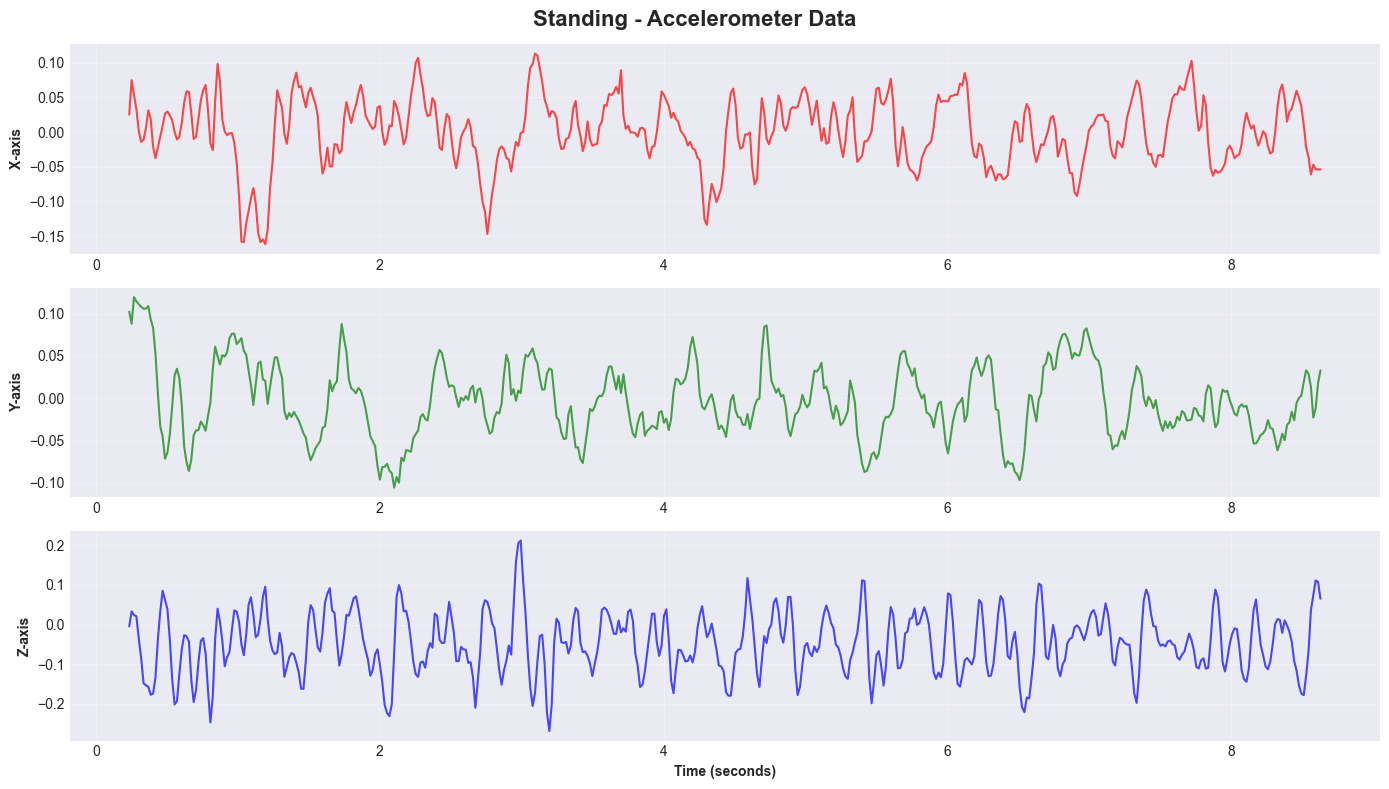

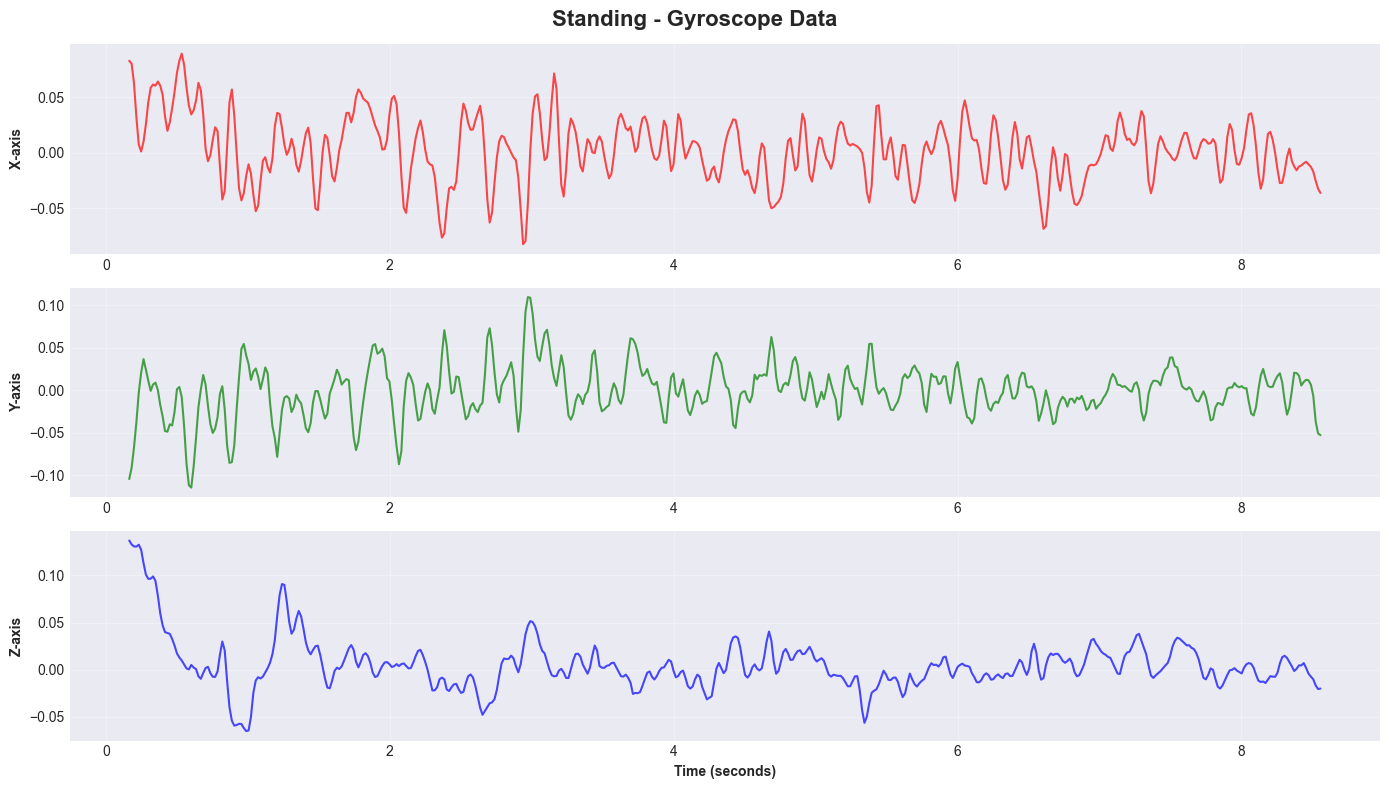


Activity: Still


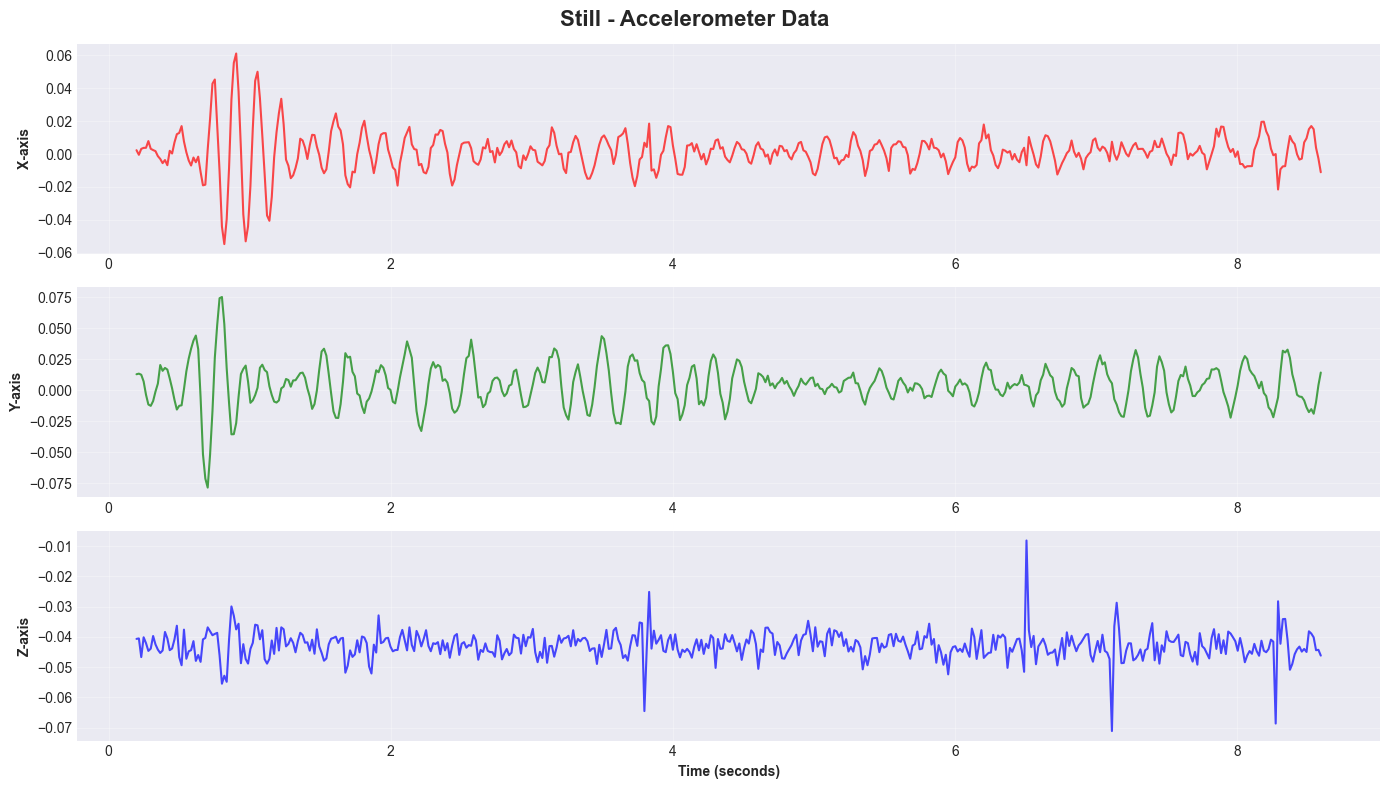

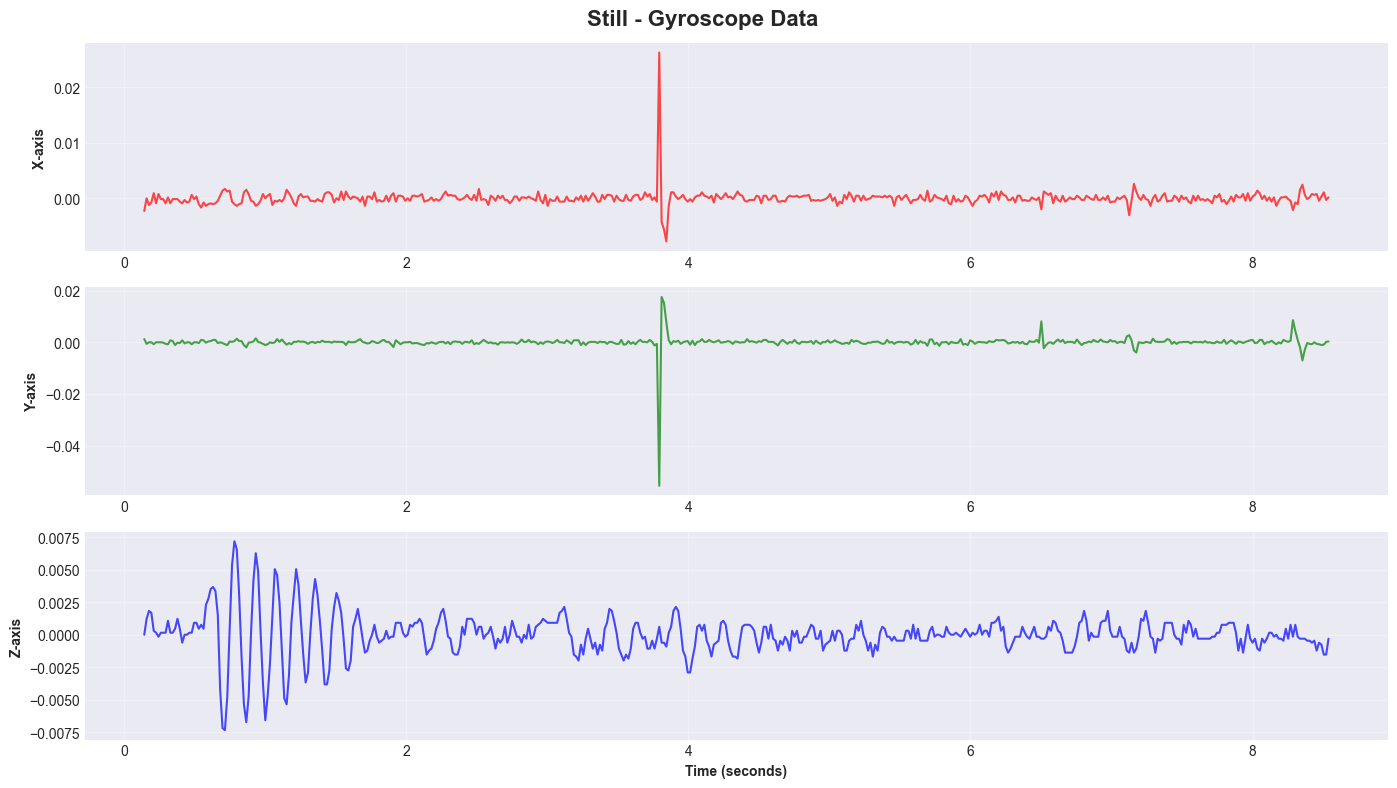


Activity: Walking


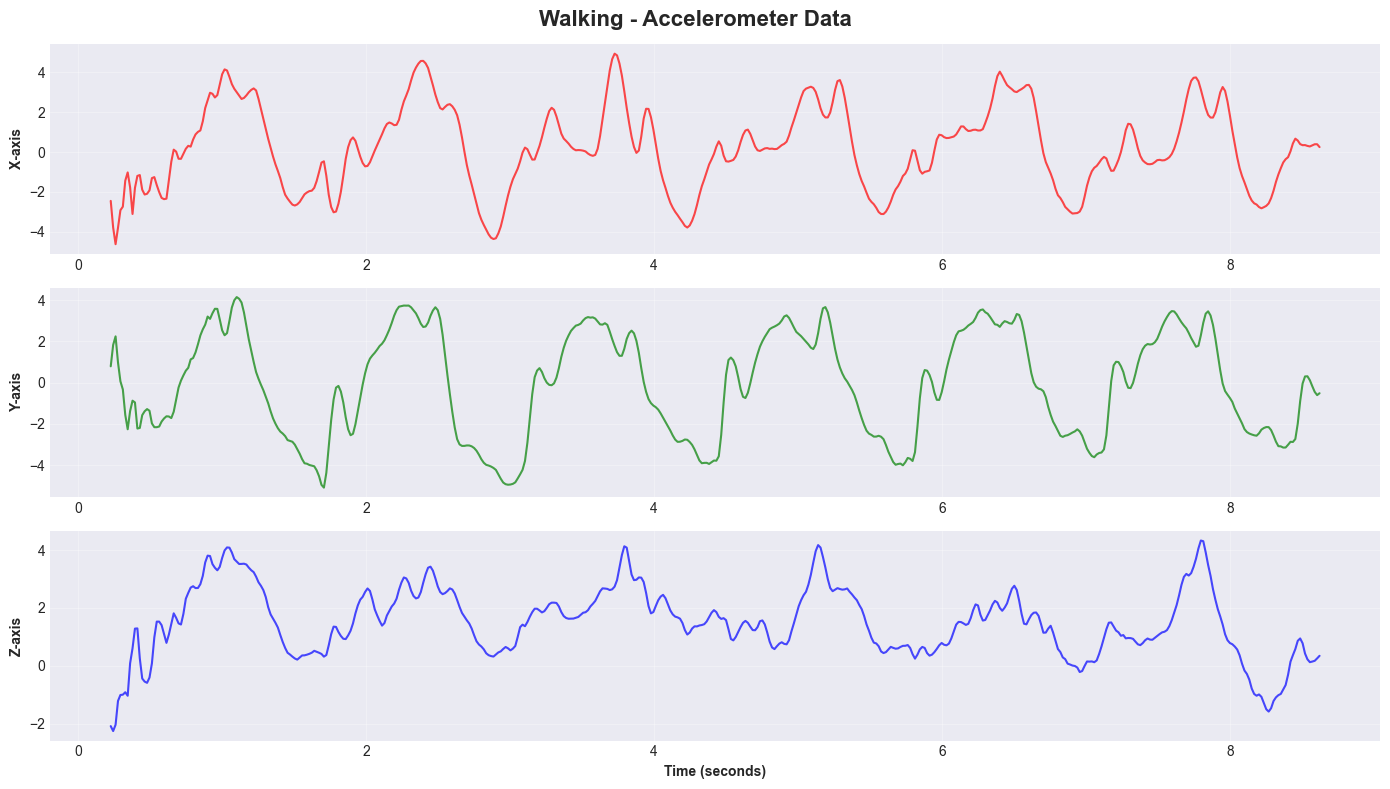

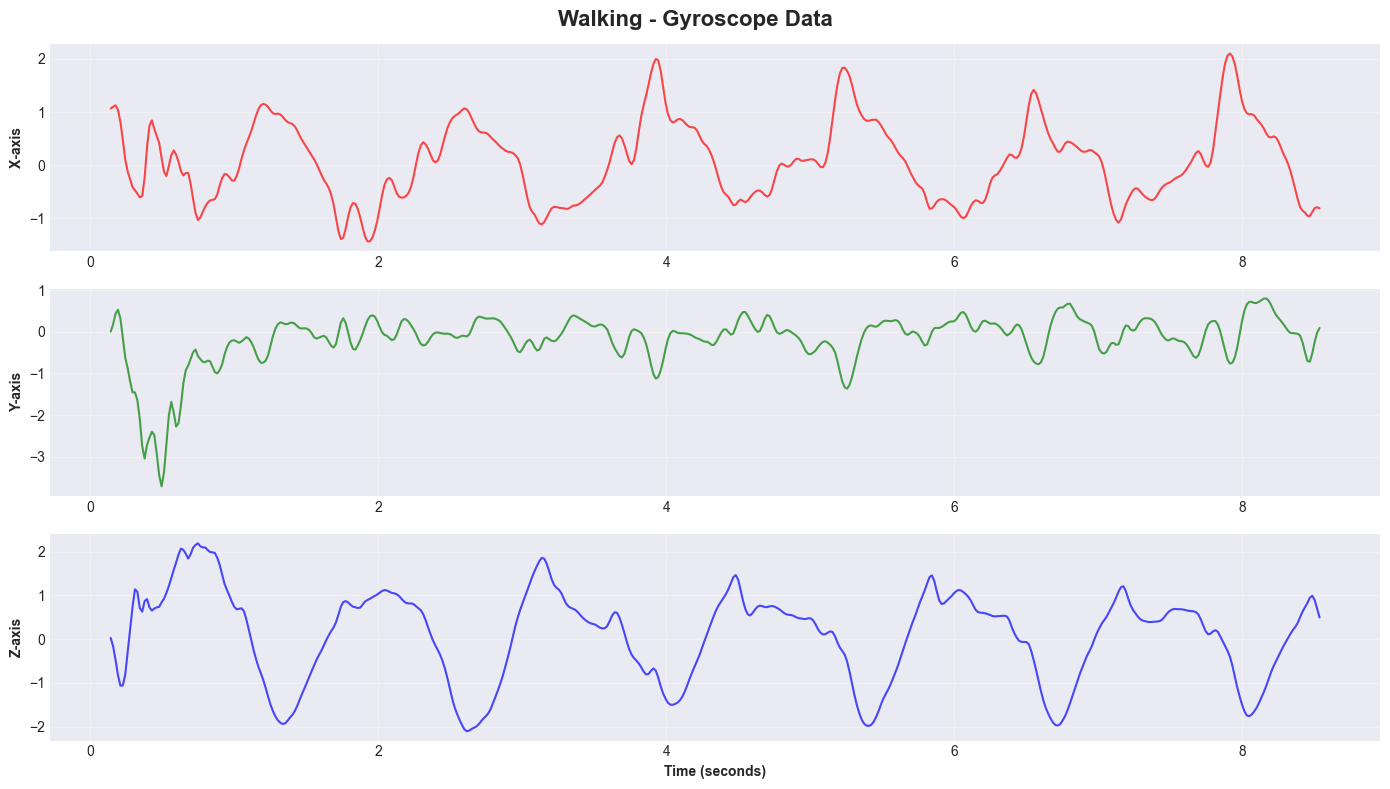

In [117]:
# Visualize Sample Data
def visualize_sensor_data(data, activity, sensor_type, sample_size=500):
    """Visualize raw sensor data for a given activity."""
    if activity in data and sensor_type in data[activity]:
        df = data[activity][sensor_type].head(sample_size)
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 8))
        fig.suptitle(f'{activity} - {sensor_type.capitalize()} Data', fontsize=16, fontweight='bold')
        
        axes[0].plot(df['seconds_elapsed'], df['x'], color='red', alpha=0.7)
        axes[0].set_ylabel('X-axis', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(df['seconds_elapsed'], df['y'], color='green', alpha=0.7)
        axes[1].set_ylabel('Y-axis', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        axes[2].plot(df['seconds_elapsed'], df['z'], color='blue', alpha=0.7)
        axes[2].set_ylabel('Z-axis', fontweight='bold')
        axes[2].set_xlabel('Time (seconds)', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Visualize all activities
for activity in ['Standing', 'Still', 'Walking']:
    print(f"\n{'='*60}")
    print(f"Activity: {activity}")
    print('='*60)
    visualize_sensor_data(sensor_data, activity, 'accelerometer')
    visualize_sensor_data(sensor_data, activity, 'gyroscope')

## 2. Feature Extraction

### Time-Domain Features:
1. **Mean** - Average value of signal
2. **Standard Deviation** - Measure of signal variability
3. **RMS (Root Mean Square)** - Energy content of signal
4. **Signal Magnitude Area (SMA)** - Overall intensity of movement
5. **Correlation between axes** - Relationship between x, y, z movements

### Frequency-Domain Features:
1. **Dominant Frequency** - Main frequency component via FFT
2. **Spectral Energy** - Total energy in frequency domain
3. **Spectral Entropy** - Measure of signal complexity

### Windowing Strategy:
- Window size will be determined based on sampling rate
- Overlapping windows for better temporal resolution

In [118]:
# Feature Extraction Functions

def calculate_time_domain_features(window_data):
    """
    Calculate time-domain features from a window of sensor data.
    
    Parameters:
    -----------
    window_data : DataFrame
        Window of sensor data with columns x, y, z
        
    Returns:
    --------
    dict : Dictionary of time-domain features
    """
    features = {}
    
    # Mean for each axis
    features['mean_x'] = window_data['x'].mean()
    features['mean_y'] = window_data['y'].mean()
    features['mean_z'] = window_data['z'].mean()
    
    # Standard deviation for each axis
    features['std_x'] = window_data['x'].std()
    features['std_y'] = window_data['y'].std()
    features['std_z'] = window_data['z'].std()
    
    # RMS (Root Mean Square) - energy content
    features['rms_x'] = np.sqrt(np.mean(window_data['x']**2))
    features['rms_y'] = np.sqrt(np.mean(window_data['y']**2))
    features['rms_z'] = np.sqrt(np.mean(window_data['z']**2))
    
    # Signal Magnitude Area (SMA) - overall intensity
    features['sma'] = (np.abs(window_data['x']).sum() + 
                       np.abs(window_data['y']).sum() + 
                       np.abs(window_data['z']).sum()) / len(window_data)
    
    # Correlation between axes
    try:
        features['corr_xy'] = window_data[['x', 'y']].corr().iloc[0, 1]
        features['corr_xz'] = window_data[['x', 'z']].corr().iloc[0, 1]
        features['corr_yz'] = window_data[['y', 'z']].corr().iloc[0, 1]
    except:
        features['corr_xy'] = 0
        features['corr_xz'] = 0
        features['corr_yz'] = 0
    
    # Magnitude
    features['magnitude_mean'] = np.sqrt(window_data['x']**2 + 
                                         window_data['y']**2 + 
                                         window_data['z']**2).mean()
    
    return features


def calculate_frequency_domain_features(window_data, sampling_rate=100):
    """
    Calculate frequency-domain features using FFT.
    
    Parameters:
    -----------
    window_data : DataFrame
        Window of sensor data with columns x, y, z
    sampling_rate : float
        Sampling rate in Hz
        
    Returns:
    --------
    dict : Dictionary of frequency-domain features
    """
    features = {}
    
    for axis in ['x', 'y', 'z']:
        signal = window_data[axis].values
        n = len(signal)
        
        if n < 2:
            features[f'dom_freq_{axis}'] = 0
            features[f'spectral_energy_{axis}'] = 0
            continue
        
        # Compute FFT
        fft_vals = fft(signal)
        fft_mag = np.abs(fft_vals[:n//2])
        freqs = fftfreq(n, 1/sampling_rate)[:n//2]
        
        # Dominant frequency
        if len(fft_mag) > 0:
            dom_freq_idx = np.argmax(fft_mag)
            features[f'dom_freq_{axis}'] = freqs[dom_freq_idx]
        else:
            features[f'dom_freq_{axis}'] = 0
        
        # Spectral energy
        features[f'spectral_energy_{axis}'] = np.sum(fft_mag**2)
        
        # Spectral entropy
        psd = fft_mag**2
        psd_norm = psd / (np.sum(psd) + 1e-10)
        features[f'spectral_entropy_{axis}'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))
    
    return features


def extract_features_from_window(window_data, sampling_rate=100):
    """
    Extract all features (time and frequency domain) from a window.
    
    Parameters:
    -----------
    window_data : DataFrame
        Window of sensor data
    sampling_rate : float
        Sampling rate in Hz
        
    Returns:
    --------
    dict : Dictionary of all features
    """
    features = {}
    
    # Time-domain features
    time_features = calculate_time_domain_features(window_data)
    features.update(time_features)
    
    # Frequency-domain features
    freq_features = calculate_frequency_domain_features(window_data, sampling_rate)
    features.update(freq_features)
    
    return features

print("✓ Feature extraction functions defined")

✓ Feature extraction functions defined


In [119]:
# Create Windows and Extract Features

def create_windows_and_extract_features(data, window_size=100, overlap=0.5):
    """
    Create overlapping windows and extract features for all activities.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing sensor data for each activity
    window_size : int
        Number of samples per window
    overlap : float
        Overlap ratio (0-1)
        
    Returns:
    --------
    DataFrame : Feature matrix with labels
    """
    all_features = []
    step_size = int(window_size * (1 - overlap))
    
    for activity in data.keys():
        print(f"\nProcessing {activity}...")
        
        for sensor_type in ['accelerometer', 'gyroscope']:
            if sensor_type not in data[activity]:
                continue
            
            df = data[activity][sensor_type]
            print(f"  {sensor_type}: {len(df)} samples")
            
            # Determine sampling rate
            if len(df) > 1:
                time_diff = df['seconds_elapsed'].diff().median()
                sampling_rate = 1 / time_diff if time_diff > 0 else 100
            else:
                sampling_rate = 100
            
            # Create windows
            num_windows = (len(df) - window_size) // step_size + 1
            
            for i in range(num_windows):
                start_idx = i * step_size
                end_idx = start_idx + window_size
                
                if end_idx > len(df):
                    break
                
                window = df.iloc[start_idx:end_idx]
                
                # Extract features
                features = extract_features_from_window(window, sampling_rate)
                features['activity'] = activity
                features['sensor'] = sensor_type
                features['window_id'] = i
                
                all_features.append(features)
            
            print(f"    Created {num_windows} windows")
    
    # Convert to DataFrame
    feature_df = pd.DataFrame(all_features)
    print(f"\n✓ Total feature vectors: {len(feature_df)}")
    print(f"✓ Features per vector: {len(feature_df.columns) - 3}")  # Exclude activity, sensor, window_id
    
    return feature_df

# Extract features with window size of 100 samples and 50% overlap
window_size = 100
overlap = 0.5
print(f"Window Configuration:")
print(f"  - Window size: {window_size} samples")
print(f"  - Overlap: {overlap*100}%")
print(f"  - Step size: {int(window_size * (1-overlap))} samples")

features_df = create_windows_and_extract_features(sensor_data, window_size, overlap)

Window Configuration:
  - Window size: 100 samples
  - Overlap: 50.0%
  - Step size: 50 samples

Processing Standing...
  accelerometer: 8451 samples
    Created 168 windows
  gyroscope: 8475 samples
    Created 168 windows
  gyroscope: 8475 samples
    Created 168 windows

Processing Still...
  accelerometer: 8912 samples
    Created 168 windows

Processing Still...
  accelerometer: 8912 samples
    Created 177 windows
  gyroscope: 8938 samples
    Created 177 windows
  gyroscope: 8938 samples
    Created 177 windows

Processing Walking...
  accelerometer: 9366 samples
    Created 177 windows

Processing Walking...
  accelerometer: 9366 samples
    Created 186 windows
  gyroscope: 9396 samples
    Created 186 windows
  gyroscope: 9396 samples
    Created 186 windows

Processing Jumping...
  accelerometer: 8608 samples
    Created 186 windows

Processing Jumping...
  accelerometer: 8608 samples
    Created 171 windows
  gyroscope: 8665 samples
    Created 171 windows
  gyroscope: 8665 

In [120]:
# Normalize Features

# Display feature summary
print("\nFeature DataFrame Info:")
print(f"Shape: {features_df.shape}")
print(f"\nActivities distribution:")
print(features_df['activity'].value_counts())
print(f"\nSensor distribution:")
print(features_df['sensor'].value_counts())

# Separate features and labels
feature_columns = [col for col in features_df.columns if col not in ['activity', 'sensor', 'window_id']]
X = features_df[feature_columns].values
y = features_df['activity'].values
sensor_types = features_df['sensor'].values

# Normalize features using Z-score normalization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

print(f"\n✓ Features normalized using Z-score standardization")
print(f"  Mean of normalized features: {X_normalized.mean():.6f}")
print(f"  Std of normalized features: {X_normalized.std():.6f}")

# Create normalized DataFrame for easier manipulation
features_normalized_df = pd.DataFrame(X_normalized, columns=feature_columns)
features_normalized_df['activity'] = y
features_normalized_df['sensor'] = sensor_types
features_normalized_df['window_id'] = features_df['window_id']

print(f"\n✓ Normalized feature matrix shape: {X_normalized.shape}")


Feature DataFrame Info:
Shape: (1405, 26)

Activities distribution:
Walking     372
Still       354
Jumping     343
Standing    336
Name: activity, dtype: int64

Sensor distribution:
gyroscope        703
accelerometer    702
Name: sensor, dtype: int64

✓ Features normalized using Z-score standardization
  Mean of normalized features: -0.000000
  Std of normalized features: 1.000000

✓ Normalized feature matrix shape: (1405, 23)


## 3. Hidden Markov Model Implementation

### HMM Components:
- **Hidden States (Z):** The underlying activities (Standing, Still, Walking)
- **Observations (X):** Feature vectors from accelerometer and gyroscope
- **Transition Probabilities (A):** P(state_t+1 | state_t)
- **Emission Probabilities (B):** P(observation | state)
- **Initial Probabilities (π):** P(state_0)

### Algorithms:
1. **Viterbi Algorithm:** Find the most likely sequence of states
2. **Baum-Welch Algorithm:** Train model parameters using EM algorithm

In [ ]:
# Hidden Markov Model Implementation

class GaussianHMM:
    """
    Hidden Markov Model with Gaussian emissions.
    Implements Viterbi algorithm for decoding and Baum-Welch for training.
    """
    
    def __init__(self, n_states, n_features):
        """
        Initialize HMM.
        
        Parameters:
        -----------
        n_states : int
            Number of hidden states
        n_features : int
            Number of features in observations
        """
        self.n_states = n_states
        self.n_features = n_features
        
        # Initialize parameters randomly
        self.start_prob = np.ones(n_states) / n_states
        self.trans_prob = np.ones((n_states, n_states)) / n_states
        
        # Gaussian emission parameters (mean and covariance for each state)
        self.means = np.random.randn(n_states, n_features)
        self.covars = np.array([np.eye(n_features) for _ in range(n_states)])
        
        self.state_names = None
        
    def _gaussian_pdf(self, X, mean, covar):
        """
        Calculate multivariate Gaussian PDF.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Observations
        mean : array, shape (n_features,)
            Mean vector
        covar : array, shape (n_features, n_features)
            Covariance matrix
            
        Returns:
        --------
        array : PDF values for each sample
        """
        n = X.shape[1]
        diff = X - mean
        
        # Add regularization to covariance for numerical stability
        covar_reg = covar + np.eye(n) * 1e-6
        
        try:
            covar_inv = np.linalg.inv(covar_reg)
            covar_det = np.linalg.det(covar_reg)
        except:
            # If singular, use identity
            covar_inv = np.eye(n)
            covar_det = 1.0
        
        norm_const = 1.0 / (np.sqrt((2 * np.pi) ** n * np.abs(covar_det)))
        exponent = -0.5 * np.sum(diff @ covar_inv * diff, axis=1)
        
        return norm_const * np.exp(exponent)
    
    def _compute_emission_prob(self, X):
        """
        Compute emission probabilities for all states and observations.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Observations
            
        Returns:
        --------
        array, shape (n_samples, n_states) : Emission probabilities
        """
        n_samples = X.shape[0]
        emission_prob = np.zeros((n_samples, self.n_states))
        
        for state in range(self.n_states):
            emission_prob[:, state] = self._gaussian_pdf(X, self.means[state], self.covars[state])
        
        # Add small epsilon to avoid log(0)
        emission_prob = np.maximum(emission_prob, 1e-10)
        
        return emission_prob
    
    def viterbi(self, X):
        """
        Viterbi algorithm to find most likely state sequence.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Sequence of observations
            
        Returns:
        --------
        array : Most likely state sequence
        """
        n_samples = X.shape[0]
        
        # Compute emission probabilities
        emission_prob = self._compute_emission_prob(X)
        
        # Initialize
        viterbi_prob = np.zeros((n_samples, self.n_states))
        viterbi_path = np.zeros((n_samples, self.n_states), dtype=int)
        
        # Initial step
        viterbi_prob[0] = np.log(self.start_prob) + np.log(emission_prob[0])
        
        # Recursion
        for t in range(1, n_samples):
            for state in range(self.n_states):
                trans_probs = viterbi_prob[t-1] + np.log(self.trans_prob[:, state])
                viterbi_path[t, state] = np.argmax(trans_probs)
                viterbi_prob[t, state] = np.max(trans_probs) + np.log(emission_prob[t, state])
        
        # Backtrack
        states = np.zeros(n_samples, dtype=int)
        states[-1] = np.argmax(viterbi_prob[-1])
        
        for t in range(n_samples - 2, -1, -1):
            states[t] = viterbi_path[t + 1, states[t + 1]]
        
        return states


✓ GaussianHMM class defined
